In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import os
import re

FRAME_PER_SECOND = 60

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 33
rcParams['xtick.labelsize'] = 33
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05

calibrations = pd.read_csv('calibracion_cinematica.csv')


FREQ_ARRAY = ['2Hz','3Hz','4Hz','5Hz','6Hz','7Hz','7.33Hz','7.66Hz','8Hz','9Hz','10Hz']
VOLT_ARRAY = ['0,5Vpp', '1,00Vpp', '1,50Vpp', '2,00Vpp', '2,50Vpp']

FREQ_ARRAY_VALUES = [2,3,4,5,6,7,7.33,7.66,8,9,10]
VOLT_ARRAY_VALUES = [0.5,1,1.5,2,2.5]

## Pendientes para la cabeza

In [2]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
csv_names = natsorted([filepath for filepath in os.listdir('ECO20-45mm/slopes-xt/cabeza') if '.csv' in filepath])
filenamelist = pd.DataFrame().assign(name = csv_names)
df = [pd.read_csv(f'ECO20-45mm/slopes-xt/cabeza/{f}') for f in filenamelist['name']]

In [3]:
f_lineal = lambda x,a,b: a*x + b

#Creating the colormap
norm_v = plt.Normalize(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cmap_v = plt.colormaps.get_cmap('viridis')
colorscale_v = plt.cm.ScalarMappable(norm_v, cmap_v)

norm_f = plt.Normalize(FREQ_ARRAY_VALUES[0],FREQ_ARRAY_VALUES[-1])
cmap_f = plt.colormaps.get_cmap('viridis')
colorscale_f = plt.cm.ScalarMappable(norm_f, cmap_f)

freq_marker = MarkerStyle("o", fillstyle="left")
volt_marker = MarkerStyle("o", fillstyle="right")

In [4]:
volt_freq_map = dict()

for currVolt in VOLT_ARRAY:

    df_namelist = filenamelist[filenamelist['name'].str.contains(currVolt)] #We get the filenames corresponding to the frequency chosen
    filtered_namelist = df_namelist['name'] #We get the names of those files


    for filename in filtered_namelist:
        
        df_txy = df[ df_namelist[df_namelist['name']==filename].index[0] ] #We retrieve the dataframe corresponding to our current filename
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
        
        popt, popv = curve_fit(f_lineal, t, x)
        err_popt = np.sqrt(np.diag(popv))
        
        volt_freq_map[popt[0]] = (vval,fval)

# pd.DataFrame(volt_freq_map.values(), index = volt_freq_map.keys(), columns=['voltage','frequency']).to_csv('slope-volt-freq-map.csv', index_label='slope')

### Pendiente en función de frecuencia

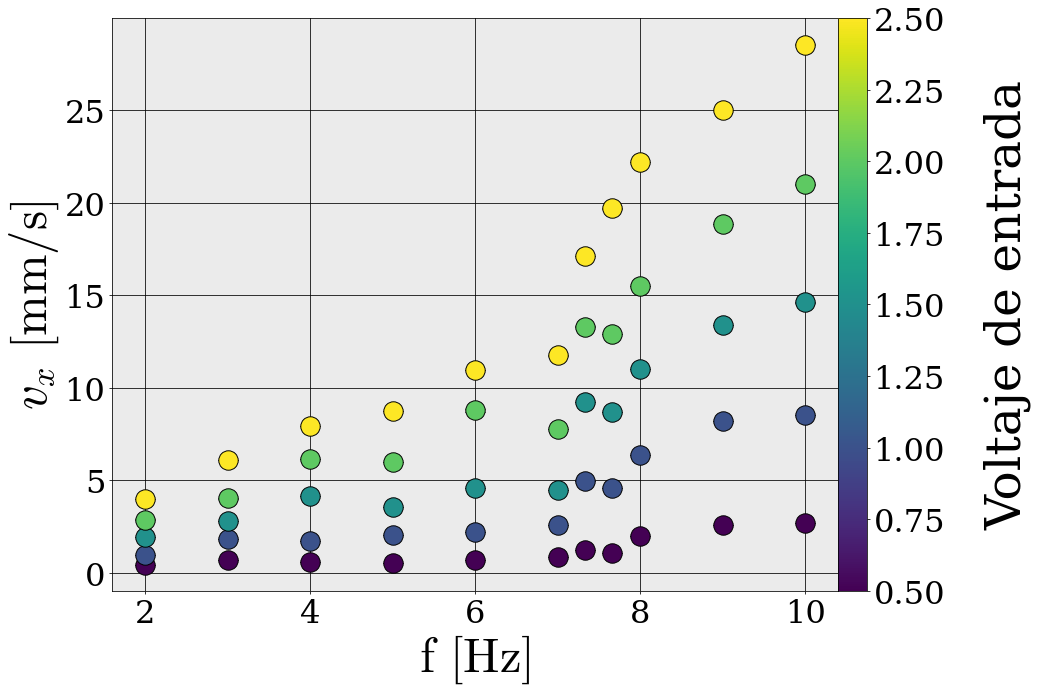

In [5]:
fig, ax = plt.subplots()

values_dict = dict({})
error_dict = dict({})

for currHz in FREQ_ARRAY:
    
    filtered_namelist = [name for name in csv_names if re.match(r'\b'+currHz+r'\b',name.split('-')[1])] #We get the names of those files

    values_dict[f'{currHz}'] = np.array([])
    error_dict[f'{currHz}'] = np.array([])

    for filename in filtered_namelist:
        df_txy = df[csv_names.index(filename)] #We retrieve the dataframe corresponding to our current filename
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('-')
        v,f = s[0],s[1][:-4]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
        
        popt, popv = curve_fit(f_lineal, t, x)
        
        err_popt = np.sqrt(np.diag(popv))
        # print(f' {v}-{f} => parametros: {popt[0]}, {popt[1]} ; errores: {err_popt[0]}, {err_popt[1]} ')
        
        values_dict[f'{currHz}'] = np.append(values_dict[f'{currHz}'],(popt[0]))
        error_dict[f'{currHz}'] = np.append(error_dict[f'{currHz}'],(err_popt[0]))
        # Plotting
        ax.errorbar(fval, np.abs(popt[0]), markerfacecolor = volt_color, fmt='o',
                    yerr = err_popt[0], xerr = None, color = 'k', ecolor = 'k',
                    ms=20, elinewidth=2, lw=3, capsize=10)

        
# Colorbar configuration

cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0)
cbar_term.ax.set_ylim(0.5,2.5)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)


# cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0)
# cbar_term.ax.set_ylim(2,10)
# cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
# cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=40)


#Axes configuration
ax.set_xlabel(f'$\\text{{f}}$ $[\\text{{Hz}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')

fig.tight_layout()
# fig.savefig(f'pendiente-en-funcion-de-frecuencia.svg', bbox_inches='tight')
# fig.savefig(f'pendiente-en-funcion-de-frecuencia.png', bbox_inches='tight')

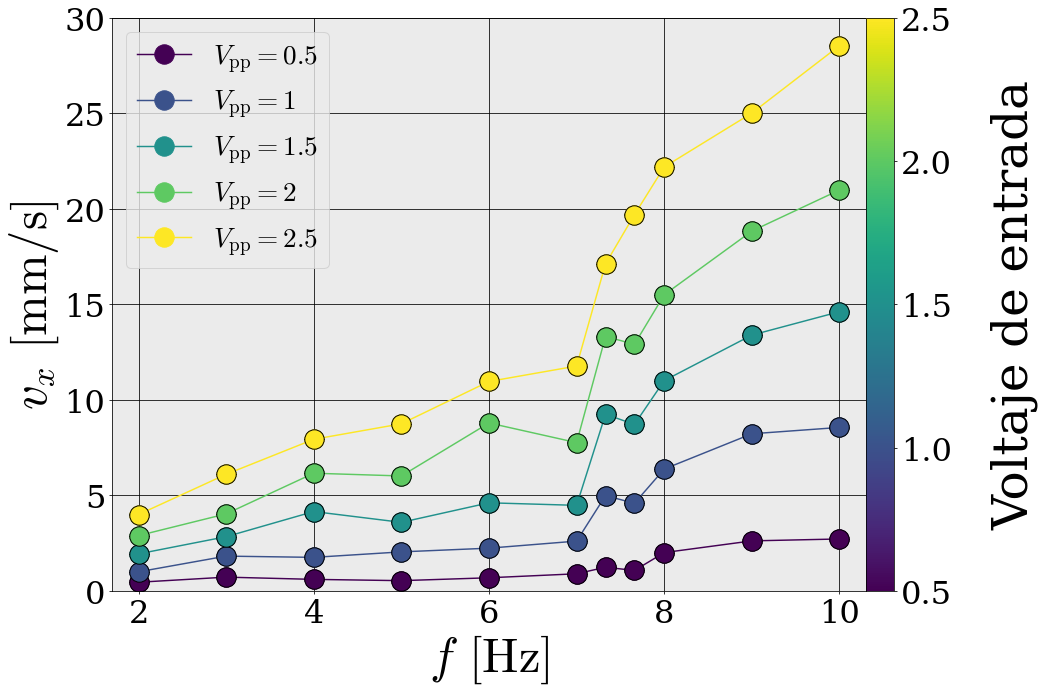

In [6]:
fig,ax = plt.subplots()
for i,vval in enumerate(VOLT_ARRAY_VALUES):
    values = np.array([values_dict[currHz][i] for currHz in FREQ_ARRAY])
    errors = np.array([error_dict[currHz][i] for currHz in FREQ_ARRAY])
    ax.plot(FREQ_ARRAY_VALUES,np.abs(values), 'o-', ms=20, color=cmap_v(norm_v(vval)), label=f'$V_\\text{{pp}} = {vval}$')
    ax.errorbar(FREQ_ARRAY_VALUES, np.abs(values), markerfacecolor = cmap_v(norm_v(vval)), fmt='o',
            yerr = errors, xerr = None, color = 'k', ecolor = 'k',
            ms=20, elinewidth=2, lw=3, capsize=10)

    
ax.set_xlabel('$f$ $\\text{[Hz]}$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')
#Colorbar configuration
cbar_term = fig.colorbar(colorscale_v, ax=ax, location='right', orientation='vertical', pad=0, fraction=0.05)
cbar_term.ax.set_ylim(VOLT_ARRAY_VALUES[0],VOLT_ARRAY_VALUES[-1])
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_yticks(VOLT_ARRAY_VALUES)
cbar_term.ax.set_ylabel('Voltaje de entrada',labelpad=40)
ax.set_xlim([1.7,10.3])
ax.set_ylim([0,30])
ax.legend()
fig.tight_layout()

### Pendiente en función de voltaje

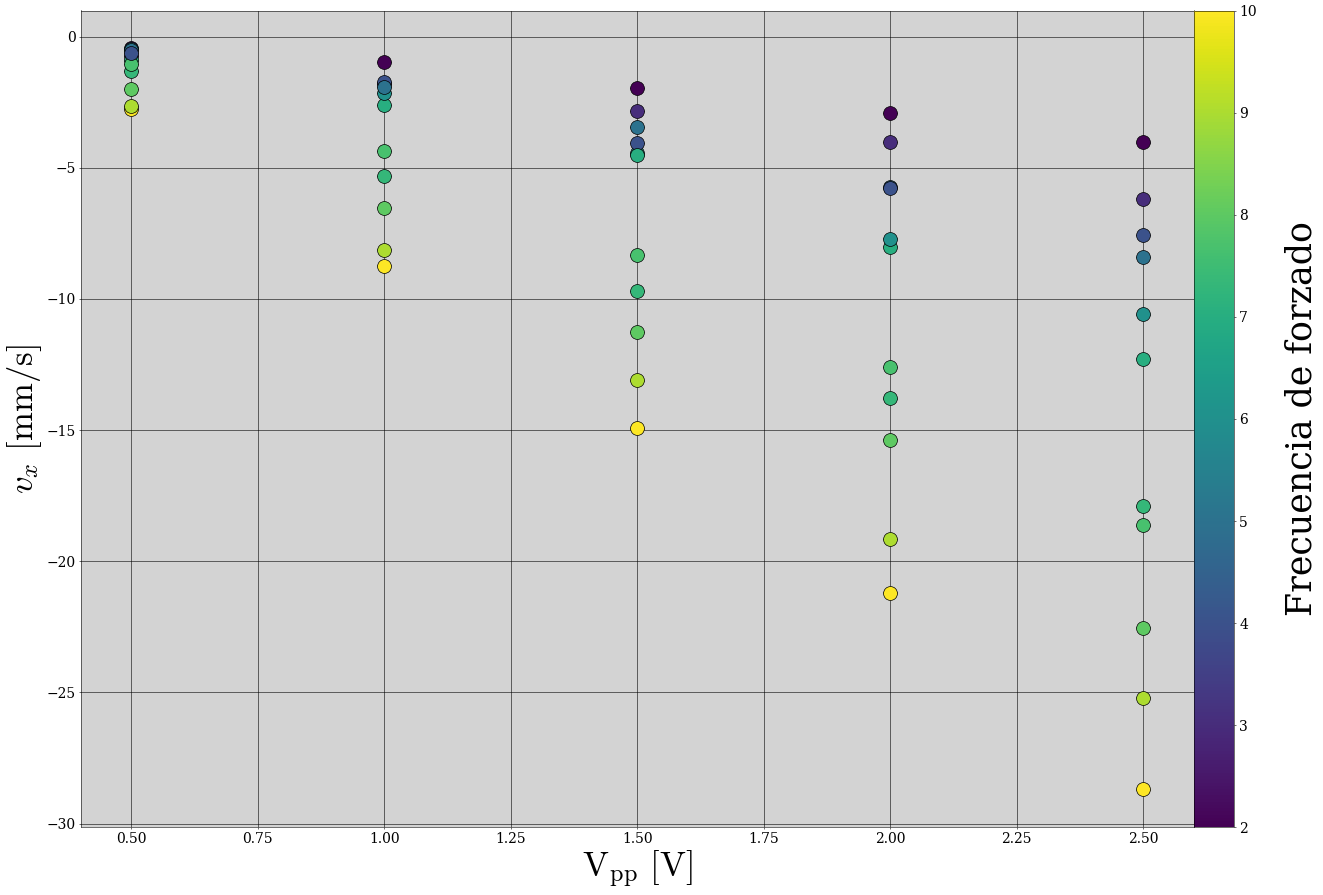

In [21]:
#We plot everything on the same two plots
fig, ax = plt.subplots()

for currVolt in VOLT_ARRAY:

    df_namelist = filenamelist[filenamelist['name'].str.contains(currVolt)] #We get the filenames corresponding to the frequency chosen
    filtered_namelist = df_namelist['name'] #We get the names of those files


    for filename in filtered_namelist:
        
        df_txy = df[ df_namelist[df_namelist['name']==filename].index[0] ] #We retrieve the dataframe corresponding to our current filename
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
        
        popt, popv = curve_fit(f_lineal, t, x)
        
        err_popt = np.sqrt(np.diag(popv))
        ax.errorbar(vval, popt[0], markerfacecolor = freq_color, fmt='o',
                yerr = err_popt[0], xerr = None, color = 'k', ecolor = 'k',
                ms=20, elinewidth=2, lw=3, capsize=10)

cbar_term = fig.colorbar(colorscale_f, ax=ax, location='right', orientation='vertical', pad=0)
cbar_term.ax.set_ylim(2,10)
cbar_term.ax.ticklabel_format(axis='x',style='sci',scilimits=(0,2))
cbar_term.ax.set_ylabel('Frecuencia de forzado',labelpad=40)


#Axes configuration
ax.set_xlabel(f'$\\text{{V}}_{{\\text{{pp}}}}$ $[\\text{{V}}]$')
ax.set_ylabel(f'$v_x$ $[\\text{{mm/s}}]$')

fig.tight_layout()
# fig.savefig(f'pendiente-en-funcion-de-voltaje.svg', bbox_inches='tight')
# fig.savefig(f'pendiente-en-funcion-de-voltaje.png', bbox_inches='tight')

### Descarga de pendientes agrupado por voltaje y frecuencia

In [13]:
volt_freq_map = dict()

for currVolt in VOLT_ARRAY:

    df_namelist = filenamelist[filenamelist['name'].str.contains(currVolt)] #We get the filenames corresponding to the frequency chosen
    filtered_namelist = df_namelist['name'] #We get the names of those files


    for filename in filtered_namelist:
        
        df_txy = df[ df_namelist[df_namelist['name']==filename].index[0] ] #We retrieve the dataframe corresponding to our current filename
        
        #We retrieve the metadata of our measurements from the filename
        s = filename.split('.')[0].split('-')
        v,f = s[0],s[1]
        vval = (float(v.split('V')[0].replace(',','.')) if 'mV' not in v else float(v.split('mV')[0].replace(',','.'))*1e-3)
        fval = float(f.split('Hz')[0].replace(',','.'))
        
        #Setting colors for our datapoints
        freq_color = cmap_f(norm_f(fval))
        volt_color = cmap_v(norm_v(vval))
        
        #We retrieve the data from our dataframe
        t,x = df_txy['t'], df_txy['x']
        
        popt, popv = curve_fit(f_lineal, t, x)
        err_popt = np.sqrt(np.diag(popv))
        
        volt_freq_map[popt[0]] = (vval,fval)

pd.DataFrame(volt_freq_map.values(), index = volt_freq_map.keys(), columns=['voltage','frequency']).to_csv('slope-volt-freq-map.csv', index_label='slope')

### Pendientes agrupado por voltaje y frecuencia

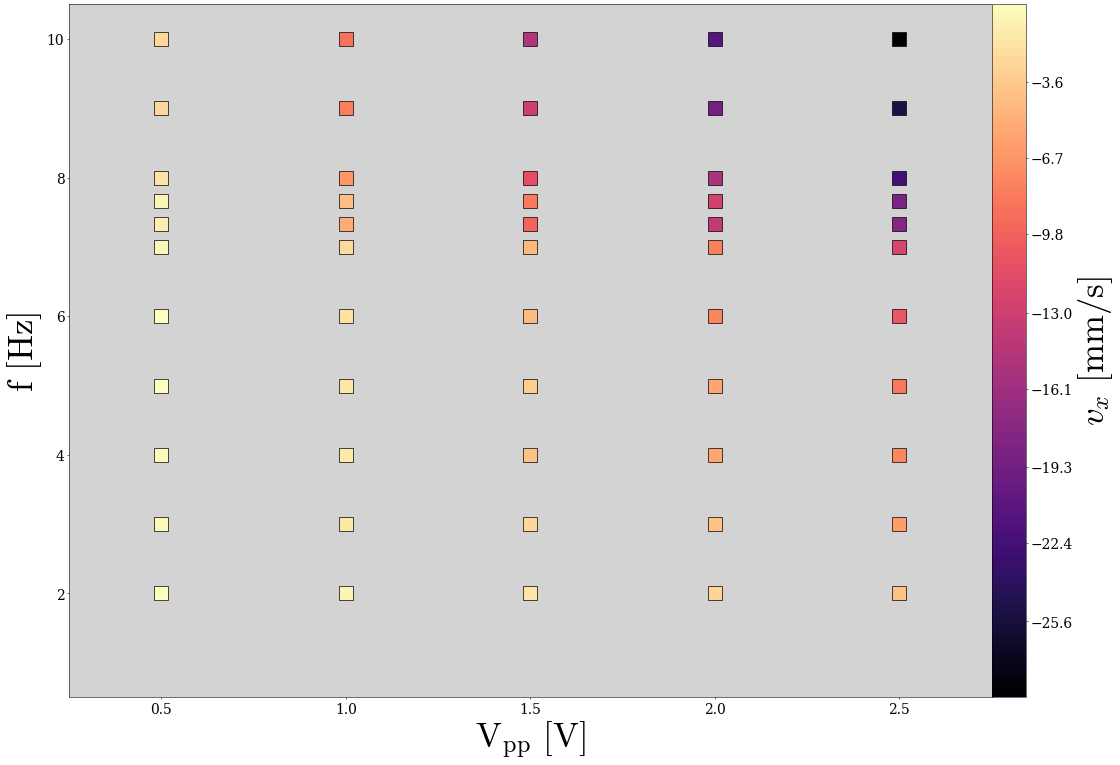

In [22]:
fig, ax = plt.subplots()

df_slopes = pd.read_csv('slope-volt-freq-map.csv')

min_slope = df_slopes['slope'].min()
max_slope = df_slopes['slope'].max()

norm = plt.Normalize(min_slope, max_slope)
cmap = plt.colormaps.get_cmap('magma')
colorscale = plt.cm.ScalarMappable(norm, cmap)


for s,v,f in df_slopes.values:
    slope_color = cmap(norm(s))
    ax.errorbar(v, f, markerfacecolor = slope_color, fmt='s',
        yerr = None, xerr = None, color = 'k', ecolor = 'k',
        ms=20, elinewidth=2, lw=3, capsize=10)

ax.set_ylim(0.5,10.5)
ax.set_xlim(0.25,2.75)

plt.colorbar(colorscale, ax=ax, location='right', orientation='vertical', pad=0,
            label = f'$v_x$ $[\\text{{mm/s}}]$',
            ticks = np.round(np.linspace(min_slope, max_slope, 10),1)
        )

ax.set_xlabel(f'$\\text{{V}}_{{\\text{{pp}}}}$ $[\\text{{V}}]$')
ax.set_ylabel(f'$\\text{{f}}$ $[\\text{{Hz}}]$')
ax.grid()